# Compare Classifier Package Tutorial
A short tutorial on comparing performances of multiple classifiers with Voting or Stacking ensemble methods. **Please note this package only works within the world of scikit-learn.**

## The Prerequisites

### Step 1: Prepare the Data

We are using a downloaded version of the [UCI Wine Quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality), named 'example_dataset.csv', stored in the project root directory. It contains physicochemical features as numerical values of wines and a target variable, column `quality` representing wine quality score. Our task is to train models to predict wine quality scores, integer values from 3 to 9 (9 = highest quality; 3 = lowest quality).

> _**Just In Case You're Wondering:**_ We changed an original dataset column, `color` containing text indicating a wine being 'red' or 'white' into a binary column now named `is_red` with 1 indicating red wine, and 0 indicating white wine. This ensures all columns are numeric and facilitates the upcoming training process for our models.

We will also need to split the dataset into `X_train`, `y_train`, `X_test`, `y_test` based on features and target variable columns, with a test dataset consisting 20% of all data. Here are some [explanations on data splitting](https://www.geeksforgeeks.org/how-to-split-the-dataset-with-scikit-learns-train_test_split-function/), if you need them. 

Now, let's take a peek at `X_train`, our training data without the target variables:

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
  
example_dataset = pd.read_csv('../example_dataset.csv')

# convert the `color` column to a binary variable: `is_red`: red = 1, white = 0, and drop the original `color` column
example_dataset['is_red'] = example_dataset['color'].apply(lambda x: 1 if x == 'red' else 0)
example_dataset = example_dataset.drop(['color'], axis=1)

# move the `color` column to the beginning
last_col = example_dataset.pop(example_dataset.columns[-1])
example_dataset.insert(0, last_col.name, last_col)

train_df, test_df = train_test_split(example_dataset, test_size=0.2)

X_train, X_test, y_train, y_test = (
    train_df.drop(columns='quality'), test_df.drop(columns='quality'),
    train_df['quality'], test_df['quality']
)

X_train

,is_red,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1256,1,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4
3963,0,6.6,0.24,0.30,11.3,0.026,11.0,77.0,0.99381,3.13,0.55,12.8
3121,0,6.5,0.32,0.23,1.2,0.054,39.0,208.0,0.99272,3.18,0.46,9.9
531,1,9.6,0.60,0.50,2.3,0.079,28.0,71.0,0.99970,3.50,0.57,9.7
546,1,7.9,0.35,0.21,1.9,0.073,46.0,102.0,0.99640,3.27,0.58,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0,6.5,0.29,0.31,1.7,0.035,24.0,79.0,0.99053,3.27,0.69,11.4
1538,0,6.1,0.41,0.14,10.4,0.037,18.0,119.0,0.99600,3.38,0.45,10.0
87,1,4.7,0.60,0.17,2.3,0.058,17.0,106.0,0.99320,3.85,0.60,12.9
1475,0,6.3,0.36,0.30,4.8,0.049,14.0,85.0,0.99320,3.28,0.39,10.6


### Step 2: Prepare Your Models

Then, we will need to build your scikit-learn machine learning models and perform [hyperparameter tuning](https://scikit-learn.org/1.5/modules/grid_search.html) to make sure they are doing the best they can. We will assume we have 5 final candidates as below. Our package functions accept the models in a list of (name, model) tuple, so we will need to convert them into something like this:

> _**Naming the Models:**_ The names you gave the models will appear in function outputs as labels. For example, for the first model in `multi_ind` below, if you want to see something more elaborate and descriptive of the model, you could write the tuple as `('Logistic Regression (C=92)', logreg)`. For simplicity's sake, we are giving our models very concise names in this tutorial.

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=92)
gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=1000)
svm = SVC(kernel='rbf', decision_function_shape='ovr', max_iter=2000)
rf = RandomForestClassifier(n_estimators=10)
knn5 = KNeighborsClassifier(n_neighbors=5)

multi_ind = [
    ('logreg', logreg),
    ('gb', gb),
    ('svm', svm),
    ('rf', rf),
    ('knn5', knn5)
]

multi_ind

[('logreg', LogisticRegression(C=92, multi_class='multinomial')),
 ('gb', GradientBoostingClassifier(learning_rate=0.001, n_estimators=1000)),
 ('svm', SVC(max_iter=2000)),
 ('rf', RandomForestClassifier(n_estimators=10)),
 ('knn5', KNeighborsClassifier())]

> _**A Note on Pipelines:**_ For simplicity's sake, all the models used in this tutorial are individual sklearn classifiers. However, sklearn pipelines are also accepted by our functions, so below is valid input models as well.

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

pipe_svm = make_pipeline(RobustScaler(), svm)
pipe_rf = make_pipeline(RobustScaler(), rf)
pipe_knn5 = make_pipeline(RobustScaler(), knn5)
pipe_gb = make_pipeline(RobustScaler(), gb)
pipe_logreg = make_pipeline(RobustScaler(), logreg)

multi_pipe = [
    ('pipe_svm', pipe_svm),
    ('pipe_rf', pipe_rf),
    ('pipe_knn5', pipe_knn5),
    ('pipe_gb', pipe_gb),
    ('pipe_logreg', pipe_logreg)
]

multi_pipe

[('pipe_svm',
  Pipeline(steps=[('robustscaler', RobustScaler()), ('svc', SVC(max_iter=2000))])),
 ('pipe_rf',
  Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('randomforestclassifier',
                   RandomForestClassifier(n_estimators=10))])),
 ('pipe_knn5',
  Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('kneighborsclassifier', KNeighborsClassifier())])),
 ('pipe_gb',
  Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('gradientboostingclassifier',
                   GradientBoostingClassifier(learning_rate=0.001,
                                              n_estimators=1000))])),
 ('pipe_logreg',
  Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('logisticregression',
                   LogisticRegression(C=92, multi_class='multinomial'))]))]

## Let's Get Started!

We recommend following all steps below for informed decision making when choosing a model for your classification task.

### Step 1: Compare Confusion Matrices for Candidate Models

A [confusion matrix](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/) is used to evaluate the performance of a classification model by comparing its predicted values against the actual values, providing a detailed breakdown of correct and incorrect predictions, allowing for a deeper analysis of the model's strengths and weaknesses beyond just overall accuracy. We can take the models we've built in `multi_ind` from the **Prerequisites - Step 3: Prepare Your Models** section and look at how each is performing by looking at their confusion matrices side-by-side to compare them.

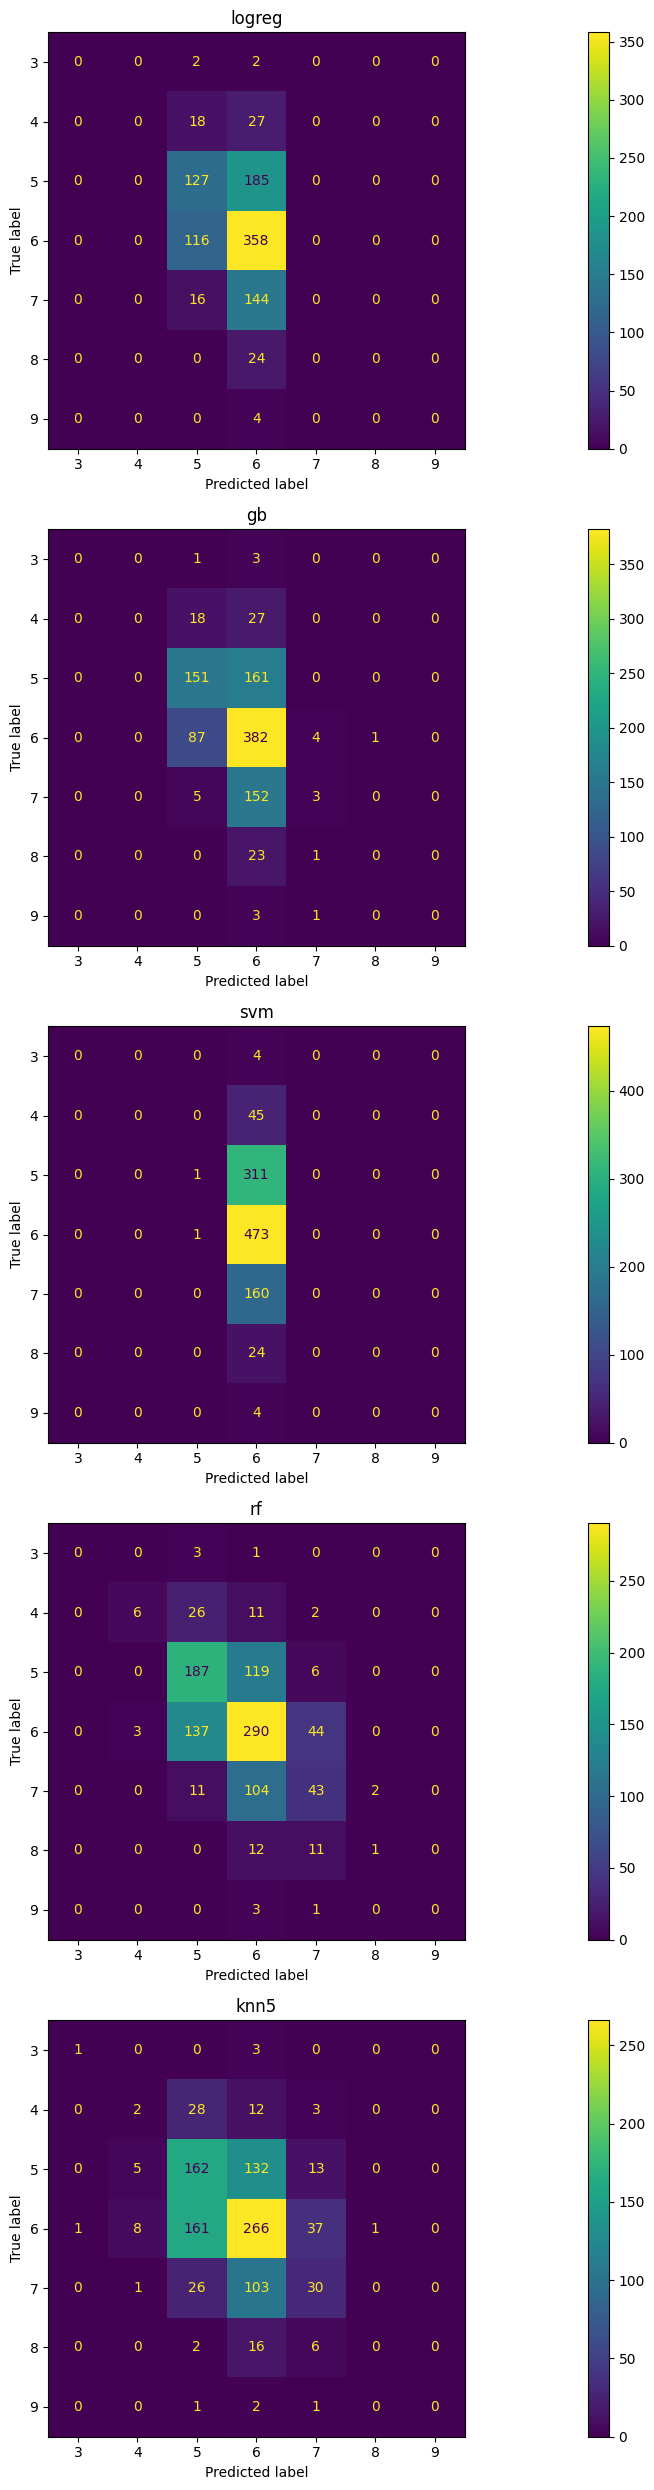

In [7]:
# We have not dealt with warning messages due to the time limit, so we will surpress them for now.
import warnings
warnings.filterwarnings("ignore")

from compare_classifiers.confusion_matrices import confusion_matrices

confusion_matrices(multi_ind, X_train, X_test, y_train, y_test);

### Step 2: Compare Fit Time and F1 Scores for Candidate Models

[F1 score](https://www.v7labs.com/blog/f1-score-guide) is a machine learning metric that measures a model's accuracy by combining its precision and recall by measuring the harmonic mean and is commonly used as an evaluation metric in binary and multi-class classification. Our package uses a macro-averaged F1 score (or macro F1 score). It is computed by taking the arithmetic mean (aka unweighted mean) of all the per-class F1 scores. This method treats all classes equally regardless of their support values.

Let's take a look at the fit times and f1 scores using 5-fold cross validation.

In [23]:
from compare_classifiers.compare_f1 import compare_f1

compare_f1(multi_ind, X_train, y_train)

,model,fit_time,test_f1_score,train_f1_score
0,logreg,0.079283,0.166500,0.156686
1,gb,39.227501,0.203310,0.425625
2,svm,0.491838,0.095170,0.089807
3,rf,0.069619,0.256010,0.968338
4,knn5,0.003149,0.195665,0.332405


_(Please excuse the low test score! Due to limited time of the project, we are using random hyperparamters and was not expecting impressing results.)_ 

### Step 3: Compare Fit Time and F1 Scores Through Voting and Stacking Ensembles

The goal of sklearn [ensemble methods](https://medium.com/@abhishekjainindore24/different-types-of-ensemble-techniques-bagging-boosting-stacking-voting-blending-b04355a03c93) is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. There are different types of combination methods to build ensembles and each one yields slightly different results. Our package has two ensembles available from sklearn: [Voting](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.VotingClassifier.html) and [Stacking](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.StackingClassifier.html) with default settings. 

Assume we've chosen the following models: `logreg`, `svm` and `knn5` as our finalists as they show the least amounts of overfitting. We can then take a look at their performances with both ensemble methods, again using 5-fold cross validation.

In [24]:
from compare_classifiers.ensemble_compare_f1 import ensemble_compare_f1

finalists = [
    ('logreg', logreg),
    ('svm', svm),
    ('knn5', knn5)
]

ensemble_compare_f1(finalists, X_train, y_train)

,method,fit_time,test_f1_score,train_f1_score
0,voting,0.565126,0.143195,0.173578
1,stacking,3.398304,0.182237,0.180828


> _**Results:**_ Each run might be different and you may now find yourself with a winning ensemble method here, or that both Voting and Stacking perform similarly.

### Step 4: Compare Ensemble Results With Individual Classifier Results

This step does not require running any package functions, but we believe it is an essential step in the comparing model performances. Since the Voting f1 score does not show a significant increase from some of our classifiers' individual f1 scores (looking at results from Step 2 above), we might want to assess whether we should choose to go forward with an ensemble model or without.

**Now, if you have decided to go with one of the existing individual classifiers you built** (because sometimes individual models can perform almost equally well as an ensemble and people may prefer using a single model because it is easier to re-train and manipulate)**, then you have already ended up with the choice of a best model!**

However, if you have decided to use an ensemble to predict instead, then in the next section, we will demonstrate how to use the Voting ensemble method to predict the target classes. 

## (Optional) Predict Using Ensemble

### Predict Unseen Data With Chosen Ensemble Method

Now it's time to put our winner ensemble method to test and have it predict some test or unseen data. We will predict on `X_test` using Voting ensemble for demonstration purpose.

> _**Note:**_ If you would like to use Stacking as the ensemble method, you would pass in 'stacking' instead of 'voting' instead.

In [29]:
from compare_classifiers.ensemble_predict import ensemble_predict

ensemble_predict(finalists, X_train, y_train, 'voting', X_test)

array([6, 6, 6, ..., 6, 6, 6], shape=(1023,))

These are the wine quality scores we get for `X_test` with our Voting ensemble classifier from the three finalist models we defined in Step 3, and here are the unique quality scores predicted!

In [30]:
import numpy as np

predictions = ensemble_predict(finalists, X_train, y_train, 'voting', X_test)

np.unique(predictions)

array([4, 5, 6, 7])